In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(
    f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")


PyTorch version: 2.0.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [2]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

# Creating the tensor product for the transformer using einsum notation

In [3]:
#for single head attention
a = torch.randint(0,10,(2,3,2,2,2))
print(a.shape)

qk = torch.einsum("bhtfe,bhtfe->bhtf", a, a)
print(qk.shape)
qkv = torch.einsum("bhtf,bhtfe->bhtfe", qk, a)
print(qkv.shape)



torch.Size([2, 3, 2, 2, 2])
torch.Size([2, 3, 2, 2])
torch.Size([2, 3, 2, 2, 2])


In [4]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

a = ["hello how are you, hello I'm good. Wassup?" , "hey there, how are you doing?"]

#add padding so all sequences are the same length
max_len = max([len(tokenizer(i)) for i in a])
a = [i + " <pad>"*(max_len - len(tokenizer(i))) for i in a]

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

for value in yield_tokens(a):
    print(value)


vocab = build_vocab_from_iterator(yield_tokens(a), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

print(vocab.get_itos())

PAD_TOKEN = vocab(tokenizer('<pad>'))
PAD_TOKEN = PAD_TOKEN[0]

print(PAD_TOKEN)

embedding = nn.Embedding(len(vocab), 3, padding_idx=PAD_TOKEN)
print(embedding)

tokenized_a = [vocab(tokenizer(i)) for i in a]
print(tokenized_a)

tokenized_a = torch.tensor(tokenized_a)
embedded_a = embedding(tokenized_a)
print(embedded_a.shape)





['hello', 'how', 'are', 'you', ',', 'hello', 'i', "'", 'm', 'good', '.', 'wassup', '?']
['hey', 'there', ',', 'how', 'are', 'you', 'doing', '?', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<unk>', '<pad>', ',', '?', 'are', 'hello', 'how', 'you', "'", '.', 'doing', 'good', 'hey', 'i', 'm', 'there', 'wassup']
1
Embedding(17, 3, padding_idx=1)
[[5, 6, 4, 7, 2, 5, 13, 8, 14, 11, 9, 16, 3], [12, 15, 2, 6, 4, 7, 10, 3, 1, 1, 1, 1, 1]]
torch.Size([2, 13, 3])


In [5]:
embedding = nn.Embedding(4, 3)
embedding(torch.tensor([1]))


tensor([[-0.7971, -0.4446,  1.9267]], grad_fn=<EmbeddingBackward0>)

In [6]:
#create some random time series data, we have n subjects, across m time points, with p features
n = 5
m = 10
p = 7

data = torch.randint(0, 10, (n,m,p))
print(data[1:3,1:3,1:3])
#lets embed the data
embedding = nn.Embedding(10, 3, padding_idx=0)
embedded_data = embedding(data)
print(embedded_data[1:3,1:3,1:3])

tensor([[[3, 2],
         [5, 4]],

        [[1, 5],
         [4, 8]]])
tensor([[[[ 1.2320,  1.4802,  0.2218],
          [-0.0478, -1.2252,  0.5683]],

         [[ 0.4990, -3.4976, -0.2068],
          [ 2.6416, -1.1588, -0.4575]]],


        [[[-1.8495, -0.3986, -0.7195],
          [ 0.4990, -3.4976, -0.2068]],

         [[ 2.6416, -1.1588, -0.4575],
          [-0.4243,  0.5956,  1.0103]]]], grad_fn=<SliceBackward0>)


# Create a Transformer

In [11]:
#create a transformer based on the tensor product above

class times_series_attention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(times_series_attention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads


        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(embed_dim, embed_dim)
        self.output_linear = nn.Linear(embed_dim, embed_dim)


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension, 
        and E is the embedding dimension
        - key: Tensor of the shape BxTxFXE
        - value: Tensor of the shape BxTxFXE
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]
        t = query.shape[1]
        f = query.shape[2]
        e = query.shape[3]


        query_linear = self.linear_query(query)
        key_linear = self.linear_key(key)
        value_linear = self.linear_value(value)

        query_reshaped = query_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        key_reshaped = key_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxE
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxE
        value_reshaped = value_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxE


        kq = torch.einsum("bhtfe,bhxye->bhtfxy", key_reshaped, query_reshaped)

        dot_prod_scores = kq/math.sqrt(self.dim_per_head)

        # if mask is not None:
        #     # We simply set the similarity scores to be near zero for the positions
        #     # where the attention should not be done. Think of why we do this.
        #     dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        #softmac across time and features
        dot_prod_scores = F.softmax(dot_prod_scores, dim=4)
        dot_prod_scores = F.softmax(dot_prod_scores, dim=5)

        out = torch.einsum("bhtfxy,bhtfe->btfhe",
                           dot_prod_scores, value_reshaped)
        out = self.output_linear(out.reshape(b, t, f, e))

        return out


In [13]:
#lets test it out
x = torch.randint(0, 10, (2,3,4,6)).float()
# mask = torch.randn((2,3,4,1)) > 0.5
num_heads = 2
embed_dim = 6
model = times_series_attention(embed_dim, num_heads)
out = model(x, x, x)
print(out.shape)


torch.Size([2, 3, 4, 6])


In [119]:
# feed forward network
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, embed_dim, ff_dim, dropout):
        """
        Inputs:
        - embed_dim: embedding dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()
        
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )

        
    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
          
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        y = self.feedforward(x)

        
        return y
        

In [120]:
#transformer cell

class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.time_series_attention = times_series_attention(embed_dim, num_heads)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.feedforward = FeedForwardNetwork(embed_dim, ff_dim, dropout)


    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        attention = self.time_series_attention(x, x, x, mask)
        attention = self.dropout(attention)
        attention = torch.add(attention, x)
        attention = self.layer_norm(attention)

        y = self.feedforward(attention)
        y = torch.add(y, attention)
        y = self.layer_norm(y)

        return y


In [121]:
# implement transformer encoder 

class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None

        self.encoder_modules = nn.ModuleList(TransformerEncoderCell(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)
          
        #y = self.layer_norm(x)
        y = x

        return y

In [169]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim=128, projection_dim=None):
        super().__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, projection_dim)

    def forward(self, diffusion_step):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1)
                               * 4.0).unsqueeze(0)  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat(
            [torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table


torch.Size([128])


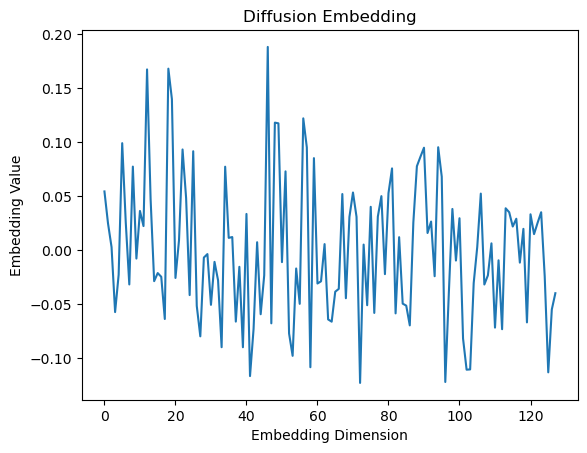

In [170]:
# let's visualize the embedding 
num_steps = 100
embedding_dim = 128
projection_dim = 128
diffusion_embedding = DiffusionEmbedding(num_steps, embedding_dim, projection_dim)
x = diffusion_embedding(10)
print(x.shape)
#plot
plt.plot(x.detach().numpy())
plt.title('Diffusion Embedding')
plt.xlabel('Embedding Dimension')
plt.ylabel('Embedding Value')
plt.show()

In [ ]:
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()
        
        self.input_dim = input_dim
        self.max_len = max_len
        
    def forward(self, x):
        """
        Compute the positional encoding and add it to x.
        
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
          
        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]
        
        pe = None
        ###########################################################################
        # TODO: Compute the positional encoding                                   #
        # Check Section 3.5 for the definition (https://arxiv.org/pdf/1706.03762.pdf)
        #                                                                         #
        # It's a bit messy, but the definition is provided for your here for your #
        # convenience (in LaTex).                                                 #
        # PE_{(pos,2i)} = sin(pos / 10000^{2i/\dmodel})                           #
        # PE_{(pos,2i+1)} = cos(pos / 10000^{2i/\dmodel})                         #
        #                                                                         #
        # You should replace 10000 with max_len here.
        ###########################################################################

        pe_row = torch.arange(seq_len)
        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((x.shape[0],1,input_dim))
        pe = pe.float()

        #torch.set_printoptions(profile="full")

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, input_dim, 2)/input_dim)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, input_dim, 2)/input_dim)))

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        x = x + pe.to(x.device)
        return x